In [74]:
import numpy as np
import matplotlib.pyplot as plt

In [75]:
# Parameters for the GA 
population_size = 80
chromosome_length = 10
num_generations = 100 
num_parents_keep = population_size // 2  
mutation_rate = 0.1

# Parameters for the problem
wavenumbers = np.linspace(6, 20, 50)
target_peaks = [8, 16]
lower_bound = 0.1 
upper_bound = 0.5

In [76]:
def target_profile(wavenumbers, peaks, width=0.1):
    y = np.zeros_like(wavenumbers)
    for peak in peaks:
        peak_range = np.abs(wavenumbers - peak) < width
        y[peak_range] = 1 - np.abs(wavenumbers[peak_range] - peak) / width
    return y

def matrix_s(n1, n2):
    return 0.5 * np.array([[1 + n2 / n1, 1 - n2 / n1], [1 - n2 / n1, 1 + n2 / n1]])

def matrix_0(k, n, d):
    exp = 1j * k / n * d
    return np.array([[np.exp(exp), 0], [0, np.exp(-exp)]], dtype=np.complex128)

def transmission(chromosome, wavenumbers, n_vec=[1, 3.17]):
    trans = []
    for k in wavenumbers:
        M = np.eye(2, dtype=np.complex128)
        for i, thickness in enumerate(chromosome):
            M = matrix_s(n_vec[i % 2], n_vec[(i + 1) % 2]) @ matrix_0(k, n_vec[i % 2], thickness) @ M
        t = np.linalg.det(M) / M[1, 1]
        trans.append(np.abs(t)**2)
    return trans

def fitness(chromosome, wavenumbers, target_peaks):
    simulated = transmission(chromosome, wavenumbers)
    target = target_profile(wavenumbers, target_peaks)
    mse = np.mean((simulated - target) ** 2)
    return 1 / mse

Generation 1: Best fitness = 63.3863622434583
Generation 2: Best fitness = 63.3863622434583
Generation 3: Best fitness = 63.3863622434583
Generation 4: Best fitness = 63.3863622434583
Generation 5: Best fitness = 63.3863622434583
Generation 6: Best fitness = 63.3863622434583
Generation 7: Best fitness = 63.3863622434583
Generation 8: Best fitness = 63.3863622434583
Generation 9: Best fitness = 63.3863622434583
Generation 10: Best fitness = 63.3863622434583
Generation 11: Best fitness = 63.3863622434583
Generation 12: Best fitness = 63.3863622434583
Generation 13: Best fitness = 305.46573764198416
Generation 14: Best fitness = 305.46573764198416
Generation 15: Best fitness = 305.46573764198416
Generation 16: Best fitness = 305.46573764198416
Generation 17: Best fitness = 305.46573764198416
Generation 18: Best fitness = 305.46573764198416
Generation 19: Best fitness = 305.46573764198416
Generation 20: Best fitness = 305.46573764198416
Generation 21: Best fitness = 504.9735373054689
Gener

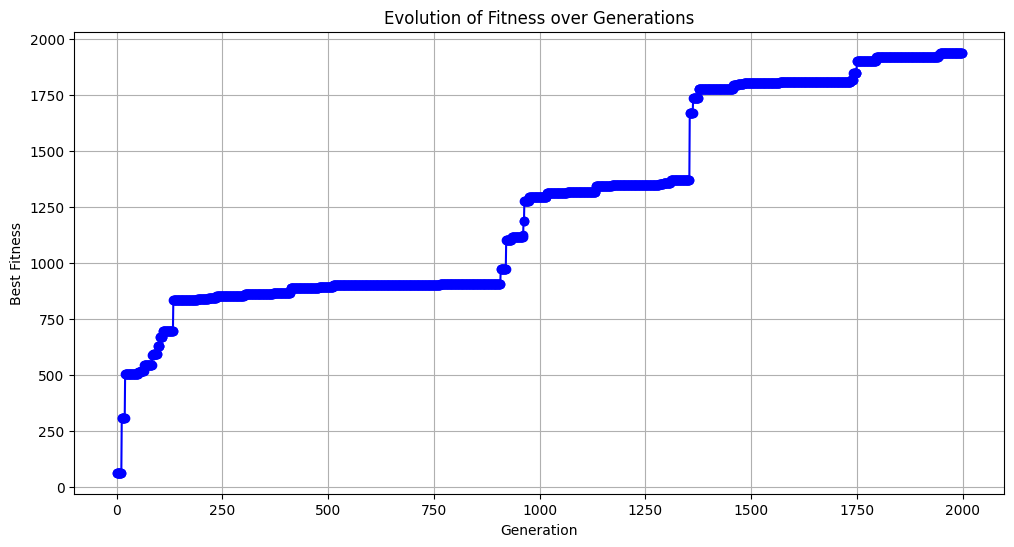

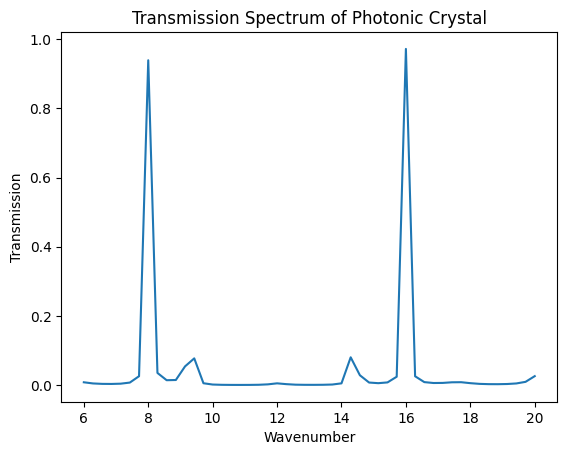

In [77]:
# Fitness function
def fitness_function(chromosome):
    return fitness(chromosome, wavenumbers, target_peaks)

# Initialization
def initialize_population(size, chromosome_length):
    return np.random.uniform(lower_bound, upper_bound, size=(size, chromosome_length))

# Evaluation
def evaluate_population(population):
    # Vectorized evaluation of the population
    return np.array([fitness_function(chromosome) for chromosome in population])

# Selection
def select_parents(population, fitness_scores, num_parents):
    # Select the top 3 best individuals (cloning)
    top_indices = np.argsort(-fitness_scores)[:3]
    top_parents = population[top_indices]

    # Adjust probabilities to exclude the top 3 best individuals
    adjusted_fitness_scores = fitness_scores.copy()
    adjusted_fitness_scores[top_indices] = 0
    total_fitness = np.sum(adjusted_fitness_scores)
    probabilities = adjusted_fitness_scores / total_fitness

    # Select the remaining parents randomly
    remaining_indices = np.random.choice(len(population), size=num_parents - 3, p=probabilities, replace=False)
    remaining_parents = population[remaining_indices]

    # Combine the top parents with the randomly selected ones
    selected_parents = np.vstack((top_parents, remaining_parents))
    return selected_parents

# Crossover
def crossover(parents, num_offspring):
    offspring = np.empty((num_offspring, parents.shape[1]))
    num_parents = parents.shape[0]
    
    for i in range(num_offspring):
        # Randomly select two parents
        parent1_idx, parent2_idx = np.random.choice(num_parents, 2, replace=False)
        parent1, parent2 = parents[parent1_idx], parents[parent2_idx]
        
        # Randomly select a crossover point
        crossover_point = np.random.randint(1, parents.shape[1])
        
        # Create offspring by combining genes from both parents
        child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
        offspring[i, :] = child
        
    return offspring

# Mutation function with Gaussian mutation
def mutate(offspring, sigma=0.1):
    for idx, _ in np.ndenumerate(offspring):
        if np.random.rand() < mutation_rate:
            offspring[idx] += np.random.normal(0, sigma)
    return offspring

# Replacement
def updated_population(population, offspring, num_parents_keep):
    fitness_scores = evaluate_population(population)
    best_indices = np.argsort(-fitness_scores)[:num_parents_keep]
    next_generation = np.empty_like(population)
    next_generation[:num_parents_keep] = population[best_indices]  # Cloning best performers
    next_generation[num_parents_keep:] = offspring[:len(population) - num_parents_keep]
    return next_generation

# GA Execution
def run_evolution(population_size, chromosome_length, num_generations, num_parents_keep):
    population = initialize_population(population_size, chromosome_length)
    best_fitness_per_generation = []

    for generation in range(num_generations):
        fitness_scores = evaluate_population(population)
        best_fitness_per_generation.append(np.max(fitness_scores))

        print('Generation {}: Best fitness = {}'.format(generation + 1, np.max(fitness_scores)))
        
        parents = select_parents(population, fitness_scores, num_parents_keep)
        
        offspring = crossover(parents, population_size - num_parents_keep)
        offspring = mutate(offspring)
        population = updated_population(population, offspring, num_parents_keep)

    return population, best_fitness_per_generation

# Run the GA
population, best_fitness_over_time = run_evolution(
    population_size, chromosome_length, num_generations, num_parents_keep
)

final_fitness_scores = evaluate_population(population)
best_index = np.argmax(final_fitness_scores)
best_chromosome = population[best_index]

print('Best chromosome:', best_chromosome)

# Plotting the best fitness over time
plt.figure(figsize=(12, 6))
plt.plot(best_fitness_over_time, marker='o', linestyle='-', color='b')
plt.title('Evolution of Fitness over Generations')
plt.xlabel('Generation')
plt.ylabel('Best Fitness')
plt.grid(True)
plt.show()

trans = transmission(best_chromosome, wavenumbers)
plt.plot(wavenumbers, trans)

# Labeling the axes
plt.xlabel('Wavenumber')
plt.ylabel('Transmission')

# You can also add a title to the plot if desired
plt.title('Transmission Spectrum of Photonic Crystal')

# Display the plot with labels
plt.show()